# Tutorial: Sleep Analysis

**Author:** Masoud Abedinifar  
**Last Update:** Tuesday, January 21, 2024

## Learning Objectives
By the end of this tutorial, you will be able to:

- Load data in `parquet` format.
- Apply the `Sleep Analysis` algorithm.
- Visualize the results of the algorithm.
- Interpret the results.


# Sleep Analysis

This example can be referenced by citing the package.

This algorithm implements a sleep analysis system to detect nocturnal rest and classify postures using accelerometer data collected from an inertial measurement unit (IMU) sensor placed on the lower back.

The process begins with the smoothing of accelerometer signals to reduce noise, followed by the detection of periods of lying based on vertical acceleration thresholds. Vertical acceleration is critical for this analysis as it represents the component of acceleration aligned with gravitational force. These periods are further refined by removing short bouts that do not meet the minimum duration criterion.

Posture classification is performed using the orientation angle (`theta`), calculated from the accelerometer's mediolateral and anterior-posterior components. The algorithm categorizes postures into four groups: back, right side, left side, and belly.

Detected events are characterized by their onset and durations. The algorithm uses a turn angle threshold to filter out minor movements, ensuring that only significant turns are included in the analysis. The results are stored in a pandas DataFrame (`posture_` attribute) in a BIDS-like format, containing details such as the onset, duration, and type of each detected event.

Optionally, if `plot_results` is set to `True`, the algorithm generates a detailed visualization of the analysis results. This includes plots of vertical acceleration, detected nocturnal rest periods, and posture classifications, offering insights into the dynamics of the analyzed data.

#### References
[`1`] Louter et al. (2015). Accelerometer-based quantitative analysis of axial nocturnal movements... https://doi.org/10.1136/jnnp-2013-306851

[`2`] Mirelman et al. (2020). Tossing and Turning in Bed: Nocturnal Movements in Parkinson's Disease... https://doi.org/10.1002/mds.28006

## Import Libraries

The necessary libraries, such as `numpy`, `matplotlib.pyplot`, `dataset`, and the `SleepAnalysis` algorithm, are imported. 

Make sure that all the required libraries and modules are installed before running this code. Additionally, you may need to install the `kielmat` library and its dependencies if they are not already installed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kielmat.modules.sa import SleepAnalysis
import matplotlib.dates as mdates

## Data Preparation

To implement the Sleep Analysis algorithm, we load example data. Two Parquet files will be used for testing the algorithm. These files include acceleration data and metadata recorded from a wearable device positioned at the lower back during the sleeping period.

In [2]:
# Relative paths to the acceleration and channel data
data_path = "./data/acceleration_data_sleep_analysis.parquet"
channels_path = "./data/channels_info_sleep_analysis.parquet"

# Load the files
accel_df = pd.read_parquet(data_path)
channels_df = pd.read_parquet(channels_path)

In [3]:
# Extract and display timestamps of data
dt_data = pd.to_datetime(accel_df["timestamp"])
print("\nTimestamps:")
print(dt_data.head())


Timestamps:
0   2019-08-01 20:30:00.000000
1   2019-08-01 20:30:00.007812
2   2019-08-01 20:30:00.015625
3   2019-08-01 20:30:00.023438
4   2019-08-01 20:30:00.031250
Name: timestamp, dtype: datetime64[ns]


In [4]:
# Extract acceleration data
accel_df = accel_df.drop(columns=["timestamp"])

# Acceleration data
print(f"Acceleration Data:", accel_df.head())

Acceleration Data:    LowerBack_ACCEL_x  LowerBack_ACCEL_y  LowerBack_ACCEL_z
0           0.024977          -0.025972           1.005035
1           0.026929          -0.023278           1.002859
2           0.025953          -0.024258           1.004068
3           0.026441          -0.021319           1.005761
4           0.026197          -0.026707           1.003826


In [5]:
# Extract acceleration unit
accel_unit = channels_df["units"].iloc[0]
print("\nAcceleration Unit:", accel_unit)


Acceleration Unit: g


In [6]:
# Extract sampling frequency of the acceleration data
sampling_frequency = channels_df["sampling_frequency"].iloc[0]
print("\nSampling Frequency:", sampling_frequency,"(Hz)")


Sampling Frequency: 128 (Hz)


#### Data Units and Conversion to SI Units

All input data provided to the modules in this toolbox should adhere to SI units to maintain consistency and accuracy across analyses. This ensures compatibility with the underlying algorithms, which are designed to work with standard metric measurements.

If any data is provided in non-SI units (e.g., acceleration in g instead of m/s²), it is needed that the data to be converted into the appropriate SI units before using it as input to the toolbox. Failure to convert non-SI units may lead to incorrect results or misinterpretation of the output.

For instance:

- **Acceleration:** Convert from g to m/s².

In [7]:
# Check unit of acceleration data
if accel_unit in ["m/s^2"]:
    pass  # No conversion needed
elif accel_unit in ["g", "G"]:
    # Convert acceleration data from "g" to "m/s^2"
    accel_df *= 9.81
    # Update unit of acceleration
    accel_unit = ["m/s^2"]

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis are plotted.

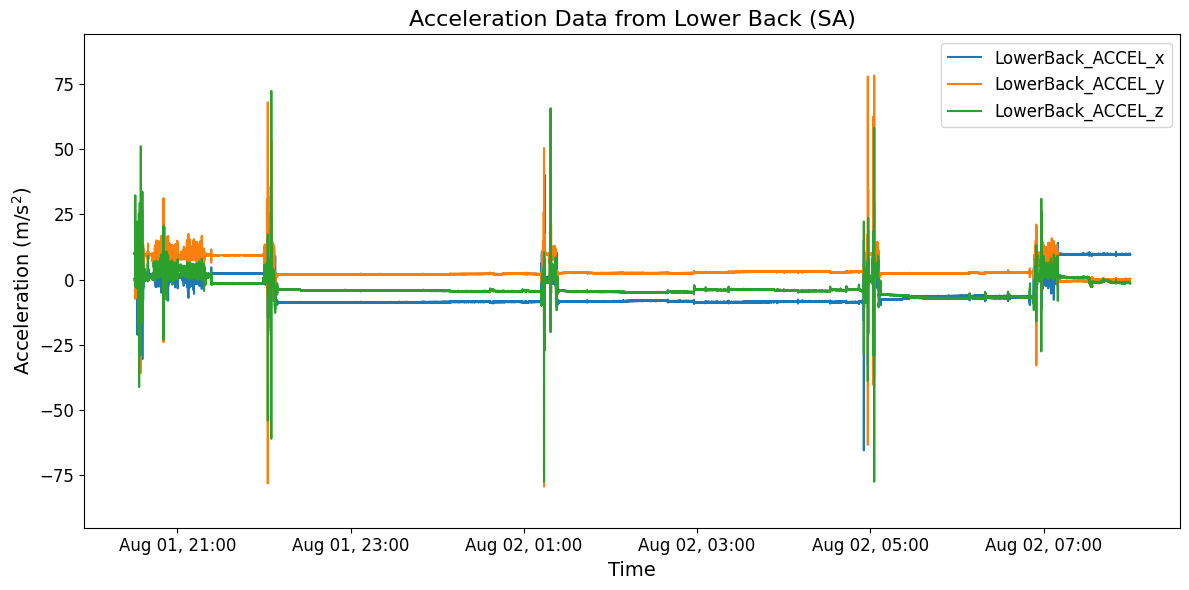

In [8]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Use time in real datetime format
time = dt_data

# Plot each acceleration component
for col in accel_df.columns:
    ax.plot(
        time, 
        accel_df[col], 
        label=col,
    )

# Set plot labels and legend
ax.set_ylabel("Acceleration (m/s$^{2}$)", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
ax.legend(loc="upper right", fontsize=12)

# Adjust the y-axis limits
accel_min = accel_df.min().min()
accel_max = accel_df.max().max()
buffer = (accel_max - accel_min) * 0.1
ax.set_ylim(accel_min - buffer, accel_max + buffer)

# Set title
ax.set_title("Acceleration Data from Lower Back (SA)", fontsize=16)

# Format the x-axis to show hours and dates
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %H:%M"))  
plt.setp(ax.get_xticklabels(), fontsize=12)  
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Applying Sleep Analysis Algorithm

To apply the Sleep Analysis algorithm, an instance of the `SleepAnalysis` class is created using the constructor, `SleepAnalysis()`. The `sleep_analyzer` variable holds this instance, allowing access to its methods. 

### Inputs of the Algorithm:
- **Acceleration Data:** `accel_data` (pd.DataFrame) includes accelerometer data (N, 3) for the x, y, and z axes in pandas DataFrame format. The unit of acceleration data should be in SI units as `m/s²`.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Vertical Acceleration:** `v_accel_col_name` is the column name corresponding to the vertical acceleration. Vertical acceleration represents the component of acceleration aligned with the gravitational force.
- **Tracking System:** `tracking_system` is the name of the tracking system, which is optional.
- **Tracked Point:** `tracked_point` is the name of the tracked point on the body, which is optional.
- **Timestamps:** `dt_data` contains the real timestamps of the acceleration data corresponding to each sample.
- **Plot Results:** `plot_results`, if set to `True`, generates a plot showing the results of the algorithm.

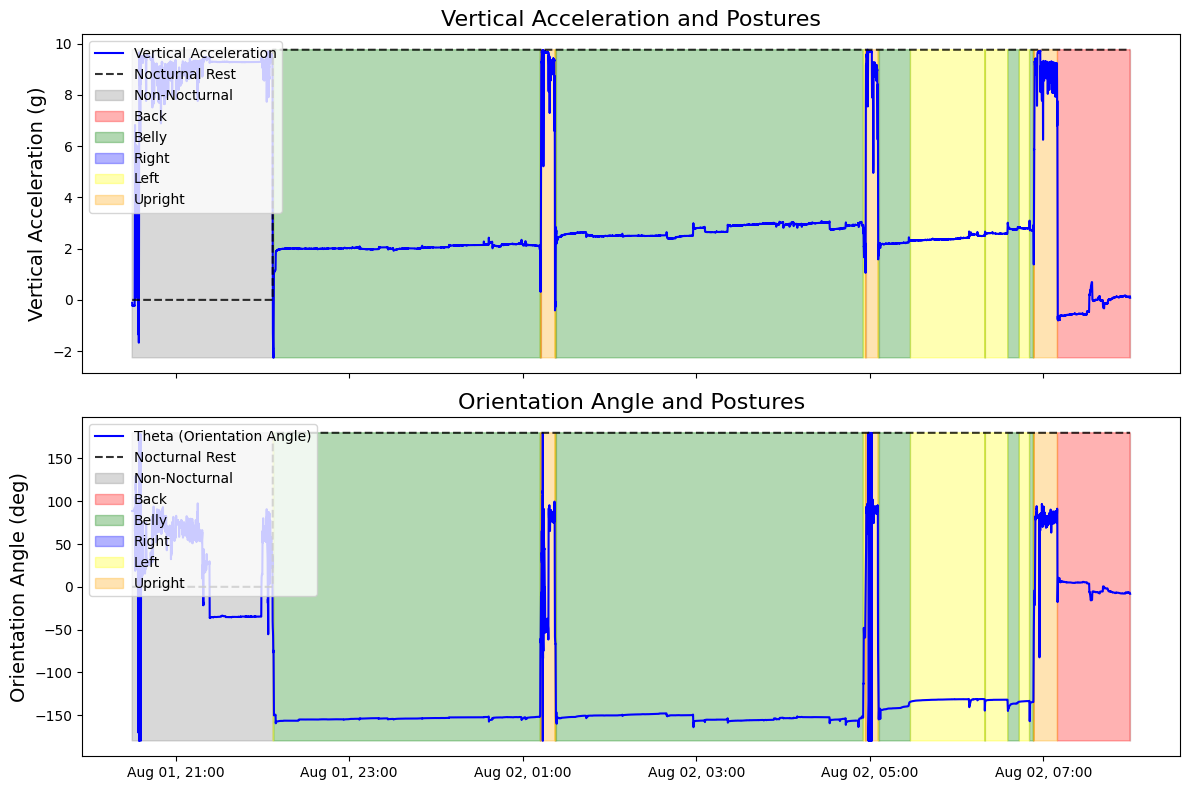

In [9]:
# Initialize the SleepAnalysis instance
sleep_analyzer = SleepAnalysis()

# Run detection and visualize results
sleep_analyzer.detect(
    accel_data=accel_df,
    v_accel_col_name="LowerBack_ACCEL_y",
    sampling_frequency_Hz=float(sampling_frequency),
    tracking_system="imu",
    tracked_point="LowerBack",
    dt_data=dt_data,
    plot_results=True
)

The outputs are stored in the `posture_` attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: The start time of the posture event, measured in seconds.
- **duration**: The duration of the posture event, measured in seconds.
- **event_type**: The type of event detected.
- **tracking_systems**: The tracking system used; for this example, it is `'imu'`.
- **tracked_points**: The tracked point on the body; for this example, it is `'LowerBack'`.

In [10]:
# Display the results
print("\nSleep Analysis Results:", sleep_analyzer.posture_)


Sleep Analysis Results:                         onset      duration     event_type tracking_system  \
0  2019-08-01 22:07:09.000000     10.796875  Non-Nocturnal             imu   
1  2019-08-01 22:07:19.796875     35.960938           Left             imu   
2  2019-08-01 22:07:55.757812  11054.046875          Belly             imu   
3  2019-08-02 01:12:09.804688     20.015625           Left             imu   
4  2019-08-02 01:12:29.820312     10.929688           Back             imu   
5  2019-08-02 01:12:40.750000    574.585938        Upright             imu   
6  2019-08-02 01:22:15.335938      1.515625           Back             imu   
7  2019-08-02 01:22:16.851562     40.085938           Left             imu   
8  2019-08-02 01:22:56.937500  12753.906250          Belly             imu   
9  2019-08-02 04:55:30.843750     84.570312           Left             imu   
10 2019-08-02 04:56:55.414062     15.742188           Back             imu   
11 2019-08-02 04:57:11.156250    512.50